# Physical modeling

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell1D.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [6]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

## Diffusion

Before we get to a Reaction-Diffusion model, we'll start with simple diffusion.

The kernel computes the difference between each cell and the sum of its neighbors.

At each time step, we compute this difference, multiply by a constant, and add it back in to the array.

在我们进入反应扩散模型之前，我们将从简单的扩散开始。
内核计算每个像元与其相邻像元之和之间的差值。
在每个时间步长中，我们计算此差异，乘以一个常量，然后将其重新添加到数组中。

In [9]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

# 定义扩散
class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""
    #以下核计算每个细胞与其邻居均值之间的差异：
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, r=0.1):
        """Initializes the attributes.

        n: number of rows
        r: diffusion rate constant
        """
        self.r = r
        self.array = np.zeros((n, n), float)
        
    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        #使用np.correlate2d，我们可以将这个核应用于数组中的每个细胞：
        c = correlate2d(self.array, self.kernel, mode='same')
        #我们将使用一个扩散常数r，它关联了浓度差与流速：
        self.array += self.r * c
        
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Reds')

Here's a simple example starting with an "island" of material in the middle.
下面是一个简单的示例，从中间的“岛屿”开始。


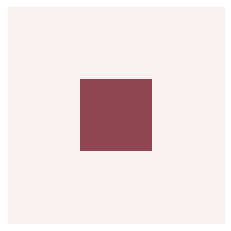

In [14]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
diff.draw()

And here's how it behaves over time: the "material" spreads out until the level is equal on the whole array.
这是它随时间推移的行为：“材料”扩散开来，直到整个阵列上的水平相等。

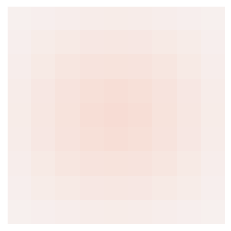

In [17]:
diff.animate(frames=30, interval=0.5)

Saving figure to file figs/chap07-1


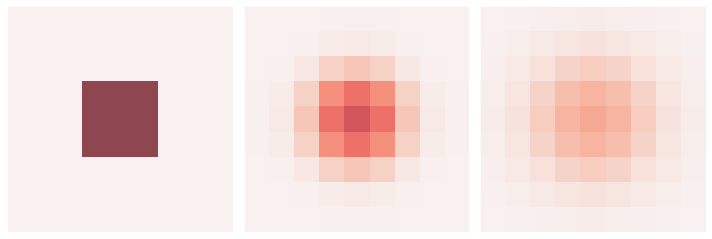

In [18]:
from utils import three_frame

diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
three_frame(diff, [0, 5, 10])

savefig('figs/chap07-1')

    ## Reaction-Diffusion

Now we'll add a second material and let them interact.

The following function helps with setting up the initial conditions.

In [26]:
def add_island(a, height=0.1):
    """Adds an island in the middle of the array.
            
    height: height of the island
    """
    n, m = a.shape
    radius = min(n, m) // 20
    i = n//2
    j = m//2
    a[i-radius:i+radius, j-radius:j+radius] += height

For the RD model, we have two arrays, one for each chemical.

Following [Sims](http://www.karlsims.com/rd.html), I'm using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell.

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.对于RD模型，我们有两个数组，每种化学品一个。
在《模拟人生》之后，我使用的是包含对角线元素的内核。它们具有较低的权重，因为它们离中心细胞更远。
阶跃函数计算以下函数：



In [27]:
class ReactionDiffusion(Diffusion):
    """Reaction-Diffusion Cellular Automaton.
    反应扩散元胞自动机。"""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    def __init__(self, n, params, noise=0.1):
        """Initializes the attributes.

        n: number of rows
        params: tuple of (Da, Db, f, k)
        """        
        self.params = params
        self.array1 = np.ones((n, n), dtype=float)
        self.array2 = noise * np.random.random((n, n))
        add_island(self.array2)
        
    def step(self):
        """Executes one time step."""
        A = self.array1
        B = self.array2
        ra, rb, f, k = self.params

        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        self.array1 += ra * cA - reaction + f * (1-A) 
        self.array2 += rb * cB + reaction - (f+k) * B
        
    def loop100(self):
        self.loop(100)
        
    def draw(self):
        """Draws the cells."""
        options = dict(interpolation='bicubic', 
                       vmin=None, vmax=None)
        draw_array(self.array1, cmap='Reds', **options)
        draw_array(self.array2, cmap='Blues', **options)

The viewer for the CA shows both arrays with some transparency, so we can see where one, the other, or both, levels are high.

Unlike previous CAs, the state of each cell is meant to represent a continuous quantity, so it is appropriate to interpolate.
CA 的查看器以一定的透明度显示两个数组，因此我们可以看到一个、另一个或两个级别都很高的位置。

与以前的 CA 不同，每个像元的状态旨在表示一个连续的量，因此适合插值。

请注意，“绘制”必须制作数组的副本，因为“步骤”会就地更新数组。


Note that `draw` has to make copies of the arrays because `step` updates the arrays in place.

Here's an example using `params3`, which yields blue dots that seem to undergo mitosis.

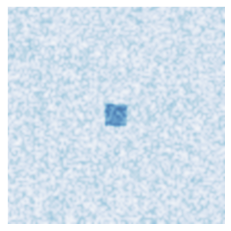

In [28]:
params1 = 0.5, 0.25, 0.035, 0.057   # pink spots and stripes
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(n=100, params=params1)
rd.draw()

Here's a random starting condition with lots of A, a sprinkling of B everywhere, and an island of B in the middle.

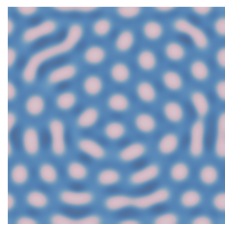

In [29]:
rd.animate(frames=50, step=rd.loop100)

I'll use the following function to generate figures using different parameters.

In [30]:
def make_rd(f, k, n=100):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params)
    return rd

The following parameters yield pink stripes and spots on a blue background:

Saving figure to file figs/chap07-2


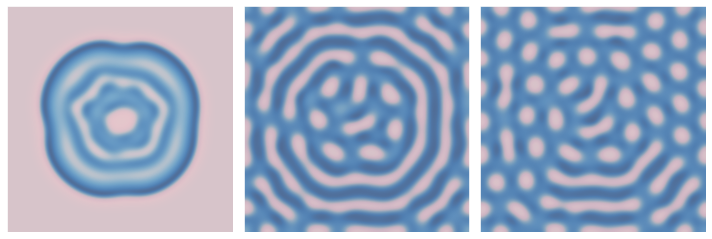

In [31]:
from utils import three_frame

def plot_rd(f, k, filename):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(100, params)

    three_frame(rd, [1000, 2000, 4000])
    
    savefig(filename)
    
plot_rd(0.035, 0.057, 'figs/chap07-2')

The following parameters yield blue stripes on a pink background.

Saving figure to file figs/chap07-3


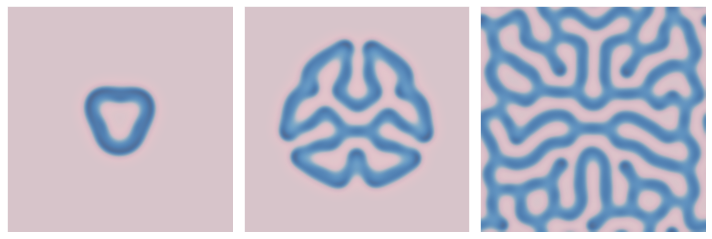

In [32]:
plot_rd(0.055, 0.062, 'figs/chap07-3')

The following parameters yield blue dots on a pink background

Saving figure to file figs/chap07-4


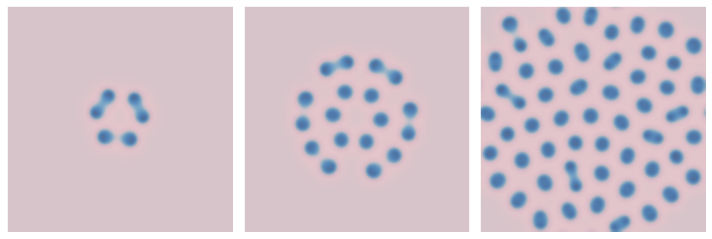

In [15]:
plot_rd(0.039, 0.065, 'figs/chap07-4')

## Percolation

In the percolation model, each cell is porous with probability `p`.  We start with a row of wet cells at the top.  During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood).  For each value of `p` we compute the probability that water reaches the bottom row.

Porous cells have state `1` and wet cells have state `5`, so if a cell has a wet neighbor, the sum of the neighbors will be `5` or more.


In [33]:
from scipy.signal import correlate2d
from Cell2D import Cell2D

class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, q=0.5):
        """Initializes the attributes.

        n: number of rows
        q: probability of porousness
        """
        self.q = q
        self.array = np.random.choice([1, 0], (n, n), p=[q, 1-q])
        
        # fill the top row with wet cells
        self.array[0] = 5

    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
        
    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Blues', vmax=5)

Here an example that shows the first three time steps.

Saving figure to file figs/chap07-5


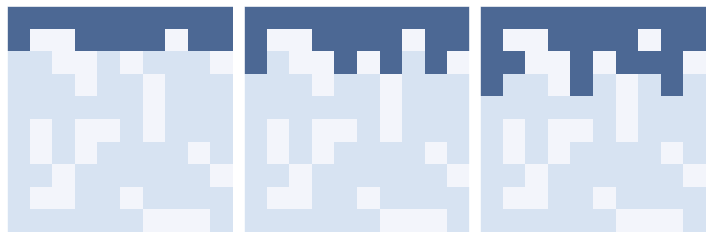

In [34]:
n = 10
q = 0.7
np.random.seed(18)
perc = Percolation(n, q)

three_frame(perc, [1, 1, 1])

savefig('figs/chap07-5')

`test_perc` runs a percolation model and returns `True` if water reaches the bottom row and `False` otherwise.

In [34]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: boolean, whether there's a percolating cluster
    """
    num_wet = perc.num_wet()

    while True:
        perc.step()

        if perc.bottom_row_wet():
            return True
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False

        num_wet = new_num_wet

Run a small example. 

In [35]:
np.random.seed(18)
perc = Percolation(n, q)
test_perc(perc)

True

And here's the animation

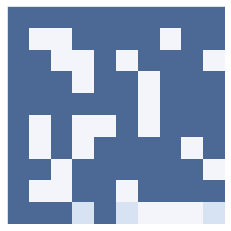

In [36]:
np.random.seed(18)
perc = Percolation(n, q)
perc.animate(frames=12, interval=0.3)

For a given `q` we can estimate the probability of a percolating cluster by running several random configurations.

In [37]:
def estimate_prob_percolating(n=100, q=0.5, iters=100):
    """Estimates the probability of percolating.
    
    n: int number of rows and columns
    q: probability that a cell is permeable
    iters: number of arrays to test
    
    returns: float probability
    """
    t = [test_perc(Percolation(n, q)) for i in range(iters)]
    return np.mean(t)

At `q=0.55` the probability is low.

In [38]:
fraction = estimate_prob_percolating(q=0.55)
print(fraction)

0.0


At `q=0.6`, the probability is close to 50%, which suggests that the critical value is nearby.

In [39]:
fraction = estimate_prob_percolating(q=0.6)
print(fraction)

0.71


At `p=0.65` the probability is high.

In [24]:
fraction = estimate_prob_percolating(q=0.65)
print(fraction)

1.0


We can search for the critical value by random walk: if there's a percolating cluster, we decrease `q`; otherwise we increase it.

The path should go to the critical point and wander around it.

In [25]:
def find_critical(n=100, q=0.6, iters=100):
    """Estimate q_crit by random walk.
    
    returns: list of q that should wander around q_crit
    """
    qs = [q]
    for i in range(iters):
        perc = Percolation(n, q)
        if test_perc(perc):
            q -= 0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

Let's see whether the critical value depends on the size of the grid.

With `n=50`, the random walk wanders around 0.59.

CPU times: user 4.3 s, sys: 6.01 ms, total: 4.3 s
Wall time: 4.31 s


0.5932367632367631

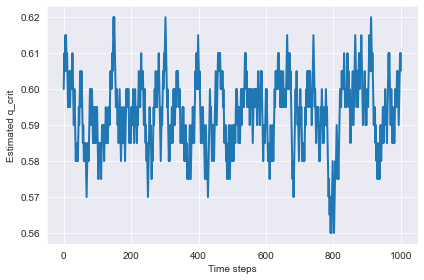

In [26]:
%time qs = find_critical(n=50, iters=1000)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Larger values of `n` don't seem to change the critical value.

CPU times: user 7.18 s, sys: 154 ms, total: 7.33 s
Wall time: 6.89 s


0.5933830845771144

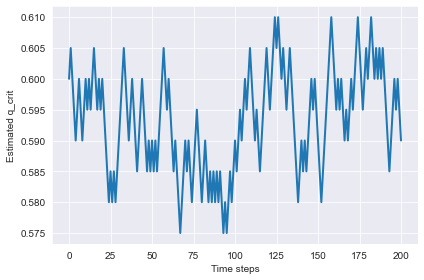

In [27]:
%time qs = find_critical(n=100, iters=200)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

CPU times: user 11.4 s, sys: 131 ms, total: 11.5 s
Wall time: 11.1 s


0.5912195121951219

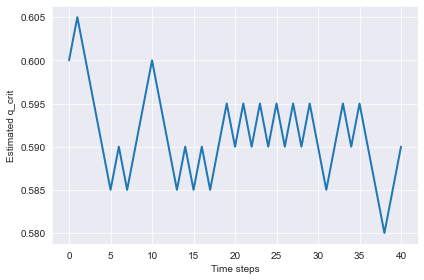

In [28]:
%time qs = find_critical(n=200, iters=40)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

CPU times: user 24.1 s, sys: 401 ms, total: 24.5 s
Wall time: 24.4 s


0.5968181818181817

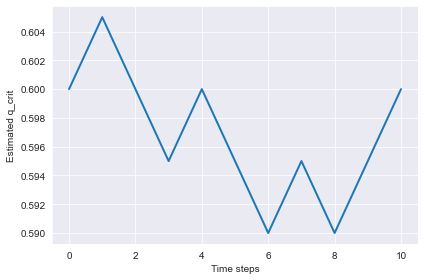

In [29]:
%time qs = find_critical(n=400, iters=10)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

## Fractals

Near the critical point, the cluster of wet cells forms a fractal.  We can see that visually in these examples:

False


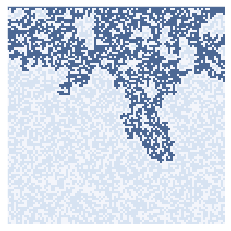

In [40]:
np.random.seed(22)
perc1 = Percolation(n=100, q=0.6)
flag = test_perc(perc1)
print(flag)
perc1.draw()

False


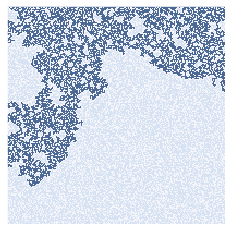

In [41]:
np.random.seed(22)
perc2 = Percolation(n=200, q=0.6)
flag = test_perc(perc2)
print(flag)
perc2.draw()

True


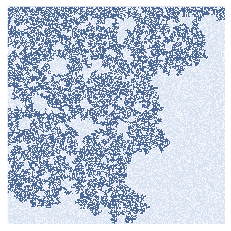

In [42]:
np.random.seed(22)
perc3 = Percolation(n=300, q=0.6)
flag = test_perc(perc3)
print(flag)
perc3.draw()

Saving figure to file figs/chap07-6


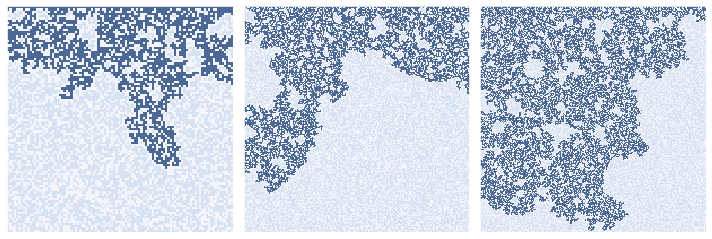

In [43]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
perc1.draw()

plt.subplot(1, 3, 2)
perc2.draw()

plt.subplot(1, 3, 3)
perc3.draw()

plt.tight_layout()
savefig('figs/chap07-6')

To measure fractal dimension, let's start with 1D CAs.

In [44]:
from Cell1D import Cell1D, draw_ca

Here's one rule that seems clearly 1D, one that is clearly 2D, and one that we can't obviously classify.

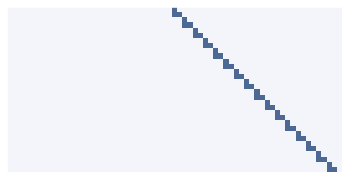

In [45]:
draw_ca(20)


Saving figure to file figs/chap07-7


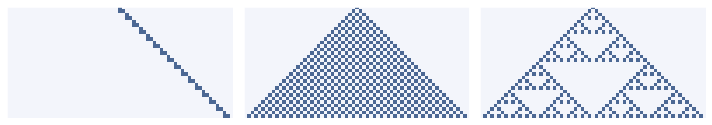

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
draw_ca(20)

plt.subplot(1, 3, 2)
draw_ca(50)

plt.subplot(1, 3, 3)
draw_ca(18)

plt.tight_layout()
savefig('figs/chap07-7')

The following function creates a 1D CA and steps through time, counting the number of on cells after each time step.

In [47]:
def count_cells(rule, n=500):
    """Create a 1-D CA and count cells.
    
    rule: int rule number
    n: number of steps
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

This function plots the results, comparing the rate of cell growth to `size` and `size**2`.

And it uses linregress to estimate the slope of the line on a log-log scale.

In [48]:
from scipy.stats import linregress

def test_fractal(rule, ylabel='Number of Cells'):
    """Compute the fractal dimension of a rule.
    
    rule: int rule number
    ylabel: string
    """
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(steps, steps2, label='d=2', **options)
    plt.plot(steps, cells, label='rule=%d' % rule)
    plt.plot(steps, steps, label='d=1', **options)

    decorate(xscale='log', yscale='log',
             xlabel='Time Steps',
             ylabel=ylabel,
             xlim=[1, 600], loc='upper left')

    params = linregress(np.log(steps), np.log(cells))
    print(params[0])

The linear rule has dimension close to 1.

1.0079212645952567


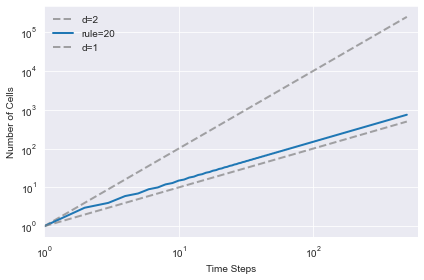

In [49]:
test_fractal(20)

The triangular rule has dimension close to 2.

1.971280883626812


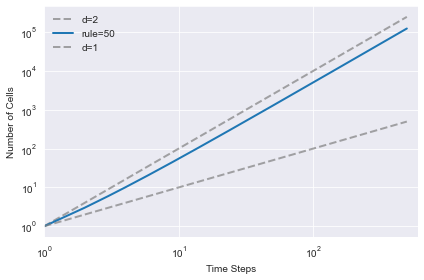

In [40]:
test_fractal(50)

And the Sierpinski triangle has fractal dimension approximately 1.57

1.5739294411777092


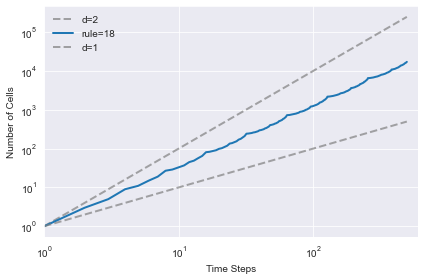

In [41]:
test_fractal(18)

1.0079212645952567
1.971280883626812
1.5739294411777092
Saving figure to file figs/chap07-8


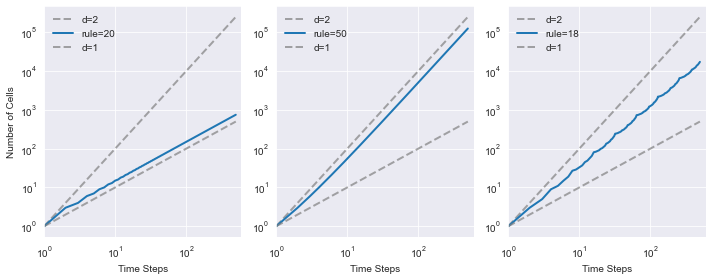

In [42]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
test_fractal(20)

plt.subplot(1, 3, 2)
test_fractal(50, ylabel='')

plt.subplot(1, 3, 3)
test_fractal(18, ylabel='')

savefig('figs/chap07-8')

Mathematically, the fractal dimension is supposed to be:

In [43]:
np.log(3) / np.log(2)

1.5849625007211563

## Fractals in percolation models

We can measure the fractal dimension of a percolation model by measuring how the number of wet cells scales as we increase the size of a bounding box.

The following function takes a sequence of sizes and the proportion of porous cells, `q`.

It run the percolation model with each of the sizes and checks whether it percolates from top to bottom.
If so, it counts the number of wet cells (subtracting off the top row, which started out wet).

In [44]:
from scipy.stats import linregress

def run_perc_scaling(sizes, q):
    res = []
    for size in sizes:
        perc = Percolation(size, q)
        if test_perc(perc):
            num_filled = perc.num_wet() - size
            res.append((size, size**2, num_filled))
        
    return np.transpose(res)

The result is an array with three rows, which we can assign to variables.

In [45]:
sizes = np.arange(10, 101)
q = 0.59
sizes, cells, filled = run_perc_scaling(sizes, q)

The following function plots the results.

In [46]:
def plot_perc_scaling(sizes, cells, filled):
    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(sizes, cells, label='d=2', **options)
    plt.plot(sizes, filled, '.', label='filled')
    plt.plot(sizes, sizes, label='d=1', **options)
    
    decorate(xlabel='Array Size',
                     ylabel='Cell Count',
                     xscale='log', xlim=[9, 110], 
                     yscale='log', ylim=[9, 20000],
                     loc='upper left')
    
    params = linregress(np.log(sizes), np.log(filled))
    print(params[0])

If we plot the number of cells versus the size of the box on a log-log scale, the slope is the fractal dimension.

When `q` is near the critical point, the fractal dimension of the wet cells is usually between 1.8 and 2.0, but it varies from one run to the next.

1.9603549799703472
Saving figure to file figs/chap07-9


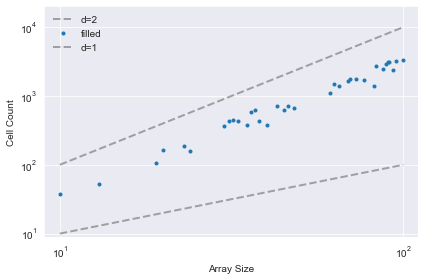

In [47]:
plot_perc_scaling(sizes, cells, filled)

savefig('figs/chap07-9')

**Exercise:** In Chapter 7 we showed that the Rule 18 CA produces a fractal.
Can you find other rules that produce fractals?  For each one,
estimate its fractal dimension.

Note: the `Cell1D` object in `Cell1D.py` does not wrap around from the left edge to the right, which creates some artifacts at the boundaries.  You might want to use `Wrap1D`, which is a child class of `Cell1D` that wraps around.

In [48]:
class Wrap1D(Cell1D):
    """Implements a 1D cellular automaton with wrapping."""

    def step(self):
        # perform the usual step operation
        Cell1D.step(self)

        # fix the first and last cells by copying from the other end
        i = self.next-1
        row = self.array[i]
        row[0], row[-1] = row[-2], row[1]   

Here's a modified version of `count_cells` that uses `Wrap1D`

In [49]:
def count_cells(rule, n=256):
    """Make a CA and count cells.
    
    rule: int rule number
    n: number of steps
    """
    ca = Wrap1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

And here's a simplified version of `test_fractal`:

In [50]:
def test_fractal(rule):
    res = count_cells(rule)
    steps, steps2, cells = np.transpose(res)

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

In [51]:
# Solution

# The following loop estimates the fractal dimension for each rule and
# makes a dictionary that maps from each unique estimate to the first
# rule that produced it.

d = {}
for rule in range(256):
    slope = test_fractal(rule)
    if slope > 1.1 and slope < 1.9:
        slope = np.around(slope, 3)
        if slope not in d:
            d[slope] = rule

In [52]:
# Solution

# This function sorts the items in a dictionary by value

def value_sorted(d):
    return sorted(d.items(), key=lambda x: x[1])

In [53]:
# Solution

# Here are the unique estimated dimensions between 1.1 and 1.9: 
    
rules = []
for slope, rule in value_sorted(d):
    print(rule, slope)
    rules.append(rule)

len(rules)

1 1.124
18 1.572
22 1.582
28 1.876
37 1.123
45 1.122
75 1.126
78 1.851
105 1.104
107 1.125
109 1.145
110 1.877
126 1.609
129 1.139
137 1.121
139 1.161
150 1.692
153 1.15
169 1.159
233 1.162


20

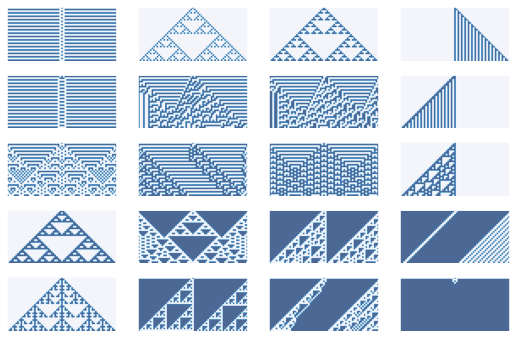

In [54]:
# Solution

# And here's what the CAs look like for the rules that seem to be fractal.
# A few of these are simple patterns that are visually not fractal, 
# but most of the ones with apparently fractional dimensions also look fractal,
# including several variations on Sierpinski's triangle. 

plt.figure(figsize=(9, 6))

for i, rule in enumerate(rules):
    plt.subplot(5, 4, i+1)
    draw_ca(rule)

**Exercise:** In 1990 Bak, Chen and Tang proposed a cellular automaton that is
an abstract model of a forest fire.  Each cell is in one of three
states: empty, occupied by a tree, or on fire.

The rules of the CA are:

* An empty cell becomes occupied with probability $p$.

* A cell with a tree burns if any of its neighbors
  is on fire.

* A cell with a tree spontaneously burns, with
  probability $f$, even if none of its neighbors is on fire.

* A cell with a burning tree becomes an empty cell in the next
  time step.

Write a
program that implements it.  You might want to inherit from `Cell2D`.
Typical values for the parameters are
$p=0.01$ and $f=0.001$, but you might want to experiment with other
values.

Starting from a random initial condition, run the CA until it reaches
a steady state where the number of trees no longer increases or
decreases consistently.  

In steady state, is the geometry of the forest fractal?
What is its fractal dimension?

In [55]:
# Here's the color map I used

from matplotlib.colors import LinearSegmentedColormap
colors = [(0,   'white'),
          (0.2, 'Green'),
          (1.0, 'Orange')]
    
cmap = LinearSegmentedColormap.from_list('mycmap', colors)

In [56]:
# Solution

# Here's a class that implements a model, using the same kernel
# as the percolation model and a similar strategy for encoding the states.

from scipy.signal import correlate2d
from Cell2D import Cell2D

class ForestFire(Cell2D):
    """Forest Fire Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, p=0.01, f=0.001):
        """Initializes the attributes.

        n: number of rows
        p: probability of a new tree
        f: probability of a random fire
        """
        self.p = p
        self.f = f
        
        self.array = np.random.choice([1, 0], (n, n), p=[p, 1-p])

    def step(self):
        """Executes one time step."""
        p, f = self.p, self.f
        a = self.array
        c = correlate2d(a, self.kernel, mode='same', boundary='wrap')
        r = np.random.random(a.shape)
        new_tree = (a==0) & (r<p)
        new_fire = (a==1) & ((c>4) | (r<f))
        a[a==5] = 0
        a[new_tree] = 1
        a[new_fire] = 5
        
    def num_trees(self, i=None):
        """Count the number of trees.
        
        i: size of box to count
        """
        a = self.array[:i, :i]
        return np.sum(a==1)
        
    def num_fires(self, i=None):
        """Count the number of fires.
        
        i: size of box to count
        """
        a = self.array[:i, :i]
        return np.sum(a==5)
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap=cmap, vmax=5)

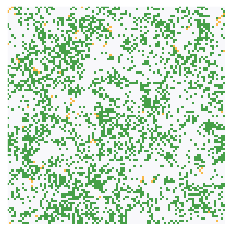

In [57]:
# Solution

# Here's an example:

fire = ForestFire(100)
fire.animate(frames=200)

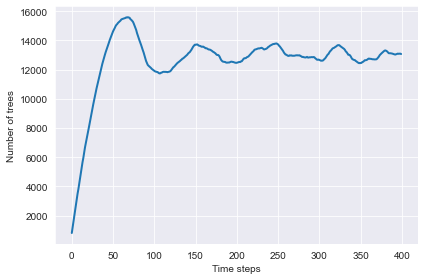

In [58]:
# Solution

# Now let's see if the forest is fractal.

# I'll create a forest and run until steady state:

np.random.seed(22)
fire = ForestFire(200)
num_trees = []
for i in range(400):
    fire.step()
    num_trees.append(fire.num_trees())
    
plt.plot(num_trees)
decorate(xlabel='Time steps',
         ylabel='Number of trees')

In [59]:
# Solution

# Now let's see how the number of trees scales as we
# increase the size of the bounding box:

res = []
sizes = range(10, 100)
for i in sizes:
    res.append((i**2, fire.num_trees(i), fire.num_fires(i)))

In [60]:
# Solution

# Extracting the results:
    
cells, trees, fires = np.transpose(res)

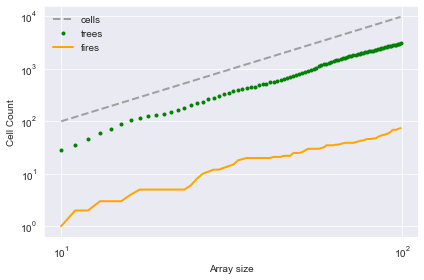

In [61]:
# Solution

# And plotting them:

options = dict(linestyle='dashed', color='gray', alpha=0.7)
plt.plot(sizes, cells, label='cells', **options)
plt.plot(sizes, trees, '.', label='trees', color='green')
plt.plot(sizes, fires, label='fires', color='orange')
decorate(xlabel='Array size',
         ylabel='Cell Count',
         xscale='log', xlim=None, 
         yscale='log', ylim=None,
         loc='upper left')

In [62]:
# Solution

# And computing the fractal dimension:
    
from scipy.stats import linregress

for ys in [cells, trees]:
    params = linregress(np.log(sizes), np.log(ys))
    print(params[0])

2.0
1.9686713241762006


In [63]:
# Solution

# The fractal dimension varies from run to run, 
# but seems to be close to 2 most of the time.
# So it's not clear whether the forest is fractal or not.